In [1]:
import transformers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import os

tf.get_logger().setLevel('ERROR')

# 1. Load BERT Model

Pretrained multi-lingual from HuggingFace

https://huggingface.co/bert-base-uncased

In [2]:
from transformers import BertTokenizer, TFBertModel

# Multi-lingual
mbertTokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
mbertModel = TFBertModel.from_pretrained("bert-base-uncased")

mbertModel.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [3]:
mbertModel.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


## Test encoding text in various languages

In [4]:
sentences = [
    'My new book is red',
    'The journal has been approved by the dean!',
    'It was a dangerous explosion caused by chemical reaction',
    'Potassium Nitrate'
]

tensors = [mbertTokeniser(s, return_tensors='tf') for s in sentences]

tensors[0]

{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[ 101, 2026, 2047, 2338, 2003, 2417,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [5]:
wouts = [mbertModel(t) for t in tensors]

In [6]:
[w for w in wouts[0]] # output structure of BERT

['last_hidden_state', 'pooler_output']

In [7]:
[w[0].numpy().shape for w in wouts] # sequence output

[(1, 7, 768), (1, 11, 768), (1, 11, 768), (1, 4, 768)]

In [8]:
[w[1].numpy().shape for w in wouts] # CLS embedding (pooled) output

[(1, 768), (1, 768), (1, 768), (1, 768)]

In [9]:
# Flatten hidden states of N words in each sentence
# by averaging
fseqs = [w[1].numpy() for w in wouts]
list(map(lambda f: f.shape, fseqs))

[(1, 768), (1, 768), (1, 768), (1, 768)]

In [10]:
encoded = mbertTokeniser.encode('Do you know who i am') # str -> ids
mbertTokeniser.convert_ids_to_tokens(encoded) # ids -> tokens

['[CLS]', 'do', 'you', 'know', 'who', 'i', 'am', '[SEP]']

Distance between each pair of sentences

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from heapq import heappush, heappop

zs = list(zip(sentences, fseqs))

closest = []
for i,(s1,v1) in enumerate(zs):
    for j,(s2,v2) in enumerate(zs[i+1:]):
        c = cosine_similarity(
            np.atleast_2d(v1.flatten()),
            np.atleast_2d(v2.flatten()))
        heappush(closest, (-c, (s1,s2)))

In [12]:
print('Top 5 closest pairs')
for i in range(5):
    c, (s1,s2) = heappop(closest)
    print('==========================')
    print(f'Rank #{i}, {-c}')
    print(s1)
    print(s2)

Top 5 closest pairs
Rank #0, [[0.97097844]]
It was a dangerous explosion caused by chemical reaction
Potassium Nitrate
Rank #1, [[0.9686246]]
The journal has been approved by the dean!
It was a dangerous explosion caused by chemical reaction
Rank #2, [[0.9531851]]
The journal has been approved by the dean!
Potassium Nitrate
Rank #3, [[0.9341798]]
My new book is red
The journal has been approved by the dean!
Rank #4, [[0.8713379]]
My new book is red
It was a dangerous explosion caused by chemical reaction


These sentence similarities make no sense at all

## Build Classification based on BERT

By freezing pretrained layer of BERT, and add a new softmax layer

In [13]:
mbertModel.trainable = False

In [14]:
mbertModel

Add custom smoothing & classification layers

In [15]:
MAX_LEN = 150

In [73]:
# input layer (1) taking tokenised words
input_ids = keras.layers.Input(
    shape=(MAX_LEN,), 
    dtype=tf.int32,
    name="input_ids")

# input layer (2) taking attention masks (masking paddings)
mask_ids = keras.layers.Input(
    shape=(MAX_LEN,),
    dtype=tf.int32,
    name="attention_mask_ids")

# input layer (3) taking token types
token_type_ids = keras.layers.Input(
    shape=(MAX_LEN,),
    dtype=tf.int32,
    name="token_type_ids")

# BERT layer, shape (768,)
outputs = mbertModel(
    input_ids,
    attention_mask=mask_ids,
    token_type_ids=token_type_ids)

# smoothening layers
logit = keras.layers.Dense(64, name="dense")(outputs[1]) # feed BERT's pooled output
logit = keras.layers.Flatten()(logit)
logit = keras.layers.Dropout(0.2, name="dropout")(logit)

act = keras.layers.Dense(
    1, name='softmax',
    activation='softmax',
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(logit)

# Modeling
model = keras.models.Model(
    inputs=[input_ids, mask_ids, token_type_ids],
    outputs=[act],
    name='BERT-clf')

In [74]:
model.summary()

Model: "BERT-clf"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
attention_mask_ids (InputLayer) [(None, 150)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask_ids[0][0]  

In [75]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(1e-5), # use low LR for BERT
    metrics=['accuracy'])

In [76]:
model.inputs

[<KerasTensor: shape=(None, 150) dtype=int32 (created by layer 'input_ids')>,
 <KerasTensor: shape=(None, 150) dtype=int32 (created by layer 'attention_mask_ids')>,
 <KerasTensor: shape=(None, 150) dtype=int32 (created by layer 'token_type_ids')>]

In [77]:
model.outputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'softmax')>]

## 2. Load tweets data
For classification

In [19]:
# Load pre-cached if exists
path_cache = os.path.join(os.environ['HOME'], 'data', 'tweets', '_cache', 'bert-tokenised.pkl')
if os.path.isfile(path_cache):
    print(f'Loading pre-cached : {path_cache}')
    tweets = pd.read_pickle(path_cache)
else:
    path_tweets = os.path.join(os.environ['HOME'], 'data', 'tweets', 'training.1600000.processed.noemoticon.csv')
    cols = ['sentiment','user','tweet']
    tweets = pd.read_csv(path_tweets, usecols=[0,4,5], header=None, index_col=None)
    tweets.columns = cols
    
    # Take only small subset
    pos = tweets[tweets['sentiment']==4].sample(n=10000, replace=False)
    neg = tweets[tweets['sentiment']==0].sample(n=10000, replace=False)
    tweets = pd.concat([pos,neg])
    tweets[:10]

Loading pre-cached : /Users/pataoengineer/data/tweets/_cache/bert-tokenised.pkl


Define attention mask and token types

In [20]:
if 'token_user' not in tweets.columns:
    def tokenise(w):
        return mbertTokeniser.encode(w)
    tokenise = np.vectorize(tokenise)
    nrecords = len(tweets)
    print(f'Tokenising users ... {nrecords}')
    tweets.loc[:,'token_user'] = tweets.loc[:,'user'].apply(tokenise)
    print(f'Tokenising tweets ... {nrecords}')
    tweets.loc[:,'token_tweet'] = tweets.loc[:,'tweet'].apply(tokenise)
    print(f'Saving to pre-cached : {path_cache}')
    tweets.to_pickle(path_cache)
else:
    print('Skipping tokenisation, already pre-computed')

Skipping tokenisation, already pre-computed


In [21]:
tweets.iloc[0]['user'] # original user

'CMGeekCrissa'

In [22]:
','.join(
    mbertTokeniser.convert_ids_to_tokens(tweets.iloc[0]['token_user']))

'[CLS],cm,##gee,##k,##cr,##issa,[SEP]'

In [23]:
','.join(
    mbertTokeniser.convert_ids_to_tokens(tweets.iloc[0]['token_tweet']))

'[CLS],@,ad,##ych,##ou,morning,ad,##y,[SEP]'

In [24]:
# find max length of vector
def get_len(tw):
    return len(tw)
max(tweets['token_tweet'].apply(get_len))

114

Concatenate user tokens and tweet tokens altogether. 
Also pad the length and record

In [25]:
def concat_ids(u, t):
    # exclude 1st [CLS] from `t`
    return u.tolist() + t[1:].tolist()

tweets.loc[:,'ids'] = tweets.apply(
    lambda row: concat_ids(row['token_user'], row['token_tweet']), axis=1)

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='len_ids'>

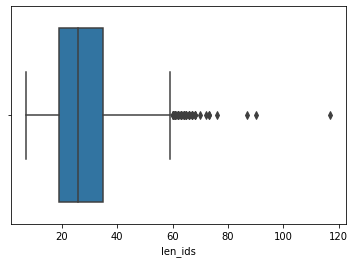

In [26]:
tweets.loc[:,'len_ids'] = tweets['ids'].apply(len)
sns.boxplot(tweets['len_ids'])

In [27]:
# pad ids with zeros so all have same length
tweets.loc[:,'ids'] = tweets.loc[:,'ids'].apply(lambda ids: \
    ids + [0]*(MAX_LEN-len(ids)))

/Users/pataoengineer/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ids'>

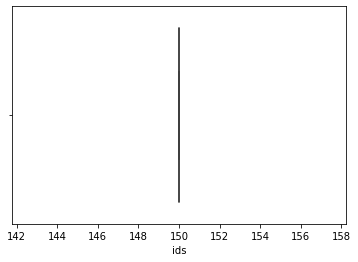

In [28]:
sns.boxplot(tweets['ids'].apply(len)) # lengths after padding

In [52]:
tweets.loc[:,'attention_mask'] = tweets['len_ids'].apply(
    lambda ld: [1]*ld + [0]*(MAX_LEN-ld))
tweets.loc[:,'token_type'] = tweets['len_ids'].apply(
    lambda ld: [1]*ld + [0]*(MAX_LEN-ld))

#sns.boxplot(tweets['attention_mask'].apply(len))

In [53]:
cols = ['ids','attention_mask','token_type']
r = tweets.iloc[0][cols]
print([type(r[c]) for c in cols])
print([len(r[c]) for c in cols])

[<class 'list'>, <class 'list'>, <class 'list'>]
[150, 150, 150]


# 3. Train first model
for classification

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
len(tweets)

20000

## Prepare dataset for TF
Dirty way. Putting all numpy vectors into ragged tensor

In [78]:
train, test = train_test_split(tweets, test_size=0.3)
len(train), len(test)

(14000, 6000)

In [79]:
ids = tf.convert_to_tensor(train['ids'].values.tolist())
mask = tf.convert_to_tensor(train['attention_mask'].values.tolist())
types = tf.convert_to_tensor(train['token_type'].values.tolist())
labels = tf.convert_to_tensor(train['sentiment'].values.tolist())

In [80]:
ids.shape, mask.shape, types.shape, labels.shape

(TensorShape([14000, 150]),
 TensorShape([14000, 150]),
 TensorShape([14000, 150]),
 TensorShape([14000]))

In [81]:
model.inputs

[<KerasTensor: shape=(None, 150) dtype=int32 (created by layer 'input_ids')>,
 <KerasTensor: shape=(None, 150) dtype=int32 (created by layer 'attention_mask_ids')>,
 <KerasTensor: shape=(None, 150) dtype=int32 (created by layer 'token_type_ids')>]

In [82]:
model.outputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'softmax')>]

Train BERT-based classification model

In [83]:
hist = model.fit(
    [ids, mask, types],
    labels,
    epochs=5,
    batch_size=200)

Epoch 1/5
70/70 [==============================] - 2650s 38s/step - loss: 5.0253 - accuracy: 0.0000e+00
Epoch 2/5
70/70 [==============================] - 2561s 37s/step - loss: 4.9667 - accuracy: 0.0000e+00
Epoch 3/5
70/70 [==============================] - 2552s 36s/step - loss: 5.0148 - accuracy: 0.0000e+00
Epoch 4/5
70/70 [==============================] - 2508s 36s/step - loss: 5.0011 - accuracy: 0.0000e+00
Epoch 5/5
70/70 [==============================] - 2486s 36s/step - loss: 5.0164 - accuracy: 0.0000e+00


## Evaluate model (offline)
with test set